# **Poject Big Data : El Nino/ La Nina**

## Before starting:

You need to install Basemap. Do it only once.

In [3]:
%%bash
apt-get install libgeos-3* libgeos-dev
pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
libgeos-3.6.2 is already the newest version (3.6.2-1build2).
libgeos-3.6.2 set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (176 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Processing t

**Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- pandas (data structures and data analysis tools)
- mpl_scatter_density (display scatter density)

In [4]:
pip install mpl-scatter-density

     |████████████████████████████████| 655kB 3.0MB/s 


In [5]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import pandas as pd
from scipy.stats.mstats import zscore
import mpl_scatter_density
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,20) # graph size

Populating the interactive namespace from numpy and matplotlib


**Declare functions:**
- plot_im (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [0]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=-85,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. using the following command. Enter the login "bigdataocean2020@gmail.com" and password "bdoimt2020_mce". Do it only once.

In [0]:
from google.colab import auth
auth.authenticate_user()

## **Part 1** : Global description

### Map SST and SSH

> Here, we study the mean SST(Sea Surface Temperature) and SSH (Sea Surface Height) in the equatorial Pacific and the correlation between the two.


In [0]:
%%bigquery --project alert-ground-261008 output0
SELECT lon, lat, AVG(sst) AS mean_sst, AVG(ssh) AS mean_ssh, corr(sst,ssh) as corr_sst_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20
GROUP BY lon, lat

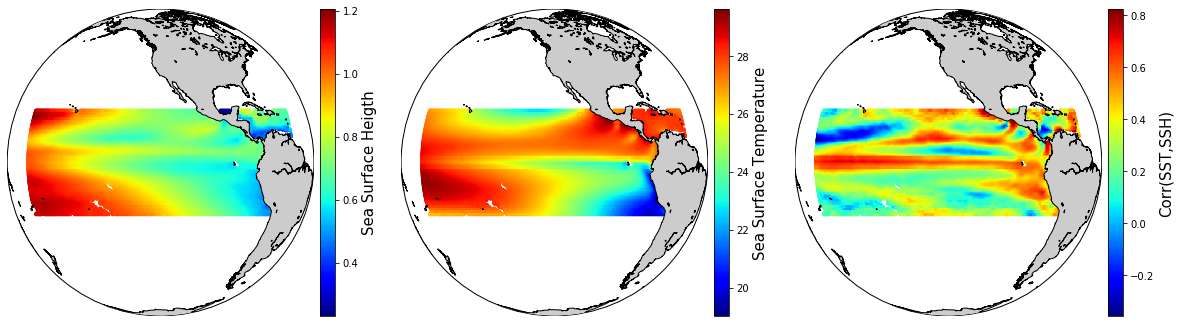

In [0]:
subplot(1,3,1)
plot_im(output0.lon,output0.lat,output0.mean_ssh,10,'Sea Surface Heigth')
subplot(1,3,2)
plot_im(output0.lon,output0.lat,output0.mean_sst,10,'Sea Surface Temperature')
subplot(1,3,3)
plot_im(output0.lon,output0.lat,output0.corr_sst_ssh,10,'Corr(SST,SSH)')

### Time series SST and SSH

> Here, we study the daily mean SST(Sea Surface Temperature) and SSH (Sea Surface Height) in the equatorial Pacific. The time series showing the anomalies in temperature (resp height) compared to the mean temperature (resp height) are shown below.

In [0]:
%%bigquery --project alert-ground-261008 output1
SELECT time, AVG(sst) AS mean_sst, AVG(ssh) AS mean_ssh, STDDEV(sst) AS std_sst, stddev(ssh) AS std_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20
GROUP BY time
ORDER by time

In [0]:
%%bigquery --project alert-ground-261008 outputavg
SELECT avg(sst) AS mean_sst, avg(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lat>-20 AND lat<20 AND lon>180 AND lon<300


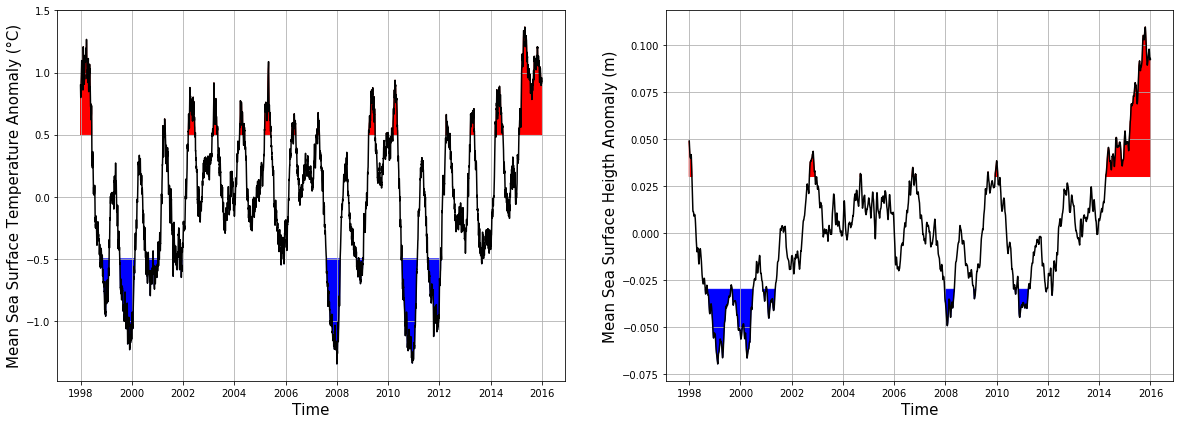

In [0]:
figure(figsize=(20,15))
subplot(2,2,1)
plot_ts(output1.time, output1.mean_sst-outputavg.mean_sst[0], '-k', 'Mean Sea Surface Temperature Anomaly (°C)')
fill_between(output1.time, output1.mean_sst-outputavg.mean_sst[0], 0.5, output1.mean_sst-outputavg.mean_sst[0]>0.5, color='r')
fill_between(output1.time, output1.mean_sst-outputavg.mean_sst[0], -0.5, output1.mean_sst-outputavg.mean_sst[0]<-0.5, color='b')
grid()
subplot(2,2,2)
plot_ts(output1.time, output1.mean_ssh-outputavg.mean_ssh[0], '-k', 'Mean Sea Surface Heigth Anomaly (m)')
fill_between(output1.time, output1.mean_ssh-outputavg.mean_ssh[0], 0.03, output1.mean_ssh-outputavg.mean_ssh[0]>0.03, color='r')
fill_between(output1.time, output1.mean_ssh-outputavg.mean_ssh[0], -0.03, output1.mean_ssh-outputavg.mean_ssh[0]<-0.03, color='b')
grid()





> Red zones correspond to high temperature compared to the average one and thus are possible El Nino events. Blue Zones are low temperatures and correspond to possible La Nina events. 





##**Part 2 :** El Nino/ La Nina  

We start by defining a function to translate time into understable dates.

In [0]:
def juld_to_greg(julian_day):
  annee = np.int(julian_day/365.25)
  mois = np.int(np.mod(julian_day,365.25)/30.5)
  jour = np.int(np.mod(np.mod(julian_day,365.25),30.5))
  return str(annee+1)+'-'+str(mois+1)+'-'+str(jour+1)

### El Nino/ La Nina intensities

Here we want to see the intensities of the different episodes to see how these intensities vary in the last years. 


We calculate the area under the curve for el Nino events.

In [0]:
Liste=output1.mean_sst-outputavg.mean_sst[0]
duree=0
el_nino1 = []
for k in range(len(Liste)):
  if Liste[k]>0.5:
    duree+=1
  elif duree >365.25/12:
    el_nino1.append([k-duree, k])
    duree=0
  else:
    duree=0
if duree!=0:
  el_nino1.append([k-duree, k])


intensity = []
test = []
dt = []
for i in range(len(el_nino1)):
  dt.append(np.ones(el_nino1[i][1] - el_nino1[i][0]))
  for j in range(el_nino1[i][1] - el_nino1[i][0]):
    test.append(output1.mean_sst[j+ el_nino1[i][0]]- outputavg.mean_sst[0])
  intensity.append(np.array(test))
  test = []

inte = []
valeur = 0
for i in range(len(intensity)):
  for j in range(intensity[i].shape[0]):
    valeur += intensity[i][j]
  inte.append(valeur)
  valeur = 0

date = []
for i in range(len(el_nino1)):
  date.append(juld_to_greg(output1.time[el_nino1[i][0]]))


For la Nina events :

In [0]:
duree=0
la_nina1 = []
for k in range(len(Liste)):
  if Liste[k]<-0.5:
    duree+=1
  elif duree >365.25/12:
    la_nina1.append([k-duree, k])
    duree=0
  else:
    duree=0
if duree!=0:
  la_nina1.append([k-duree, k])


intensitynina = []
testnina = []
for i in range(len(la_nina1)):
  for j in range(la_nina1[i][1] - la_nina1[i][0]):
    testnina.append(output1.mean_sst[j+ la_nina1[i][0]]- outputavg.mean_sst[0])
  intensitynina.append(np.array(testnina))
  testnina = []

intenina = []
valeurnina = 0
for i in range(len(intensitynina)):
  for j in range(intensitynina[i].shape[0]):
    valeurnina += abs(intensitynina[i][j])
  intenina.append(valeurnina)
  valeurnina = 0


datenina = []
for i in range(len(la_nina1)):
  datenina.append(juld_to_greg(output1.time[la_nina1[i][0]]))



The following code is just to put together two events that are actually the same.

In [0]:
inte[8] = inte[8]+inte[9]
del inte[9]
del date[9]

intenina[2] = intenina[2] + intenina[3]
del datenina[3]
del intenina[3]


[156.4970709657117, 64.84494992585317, 42.857313040305534, 33.10173778830857, 66.32916555212154, 18.185472428380763, 65.00031717477981, 51.72723433324363, 108.98141532797214, 328.83942960750034]


Then we plot the different intensities for El Nino and for La nina.

Text(0.5, 1.0, 'Intensity of each ENSO < -0.5°C')

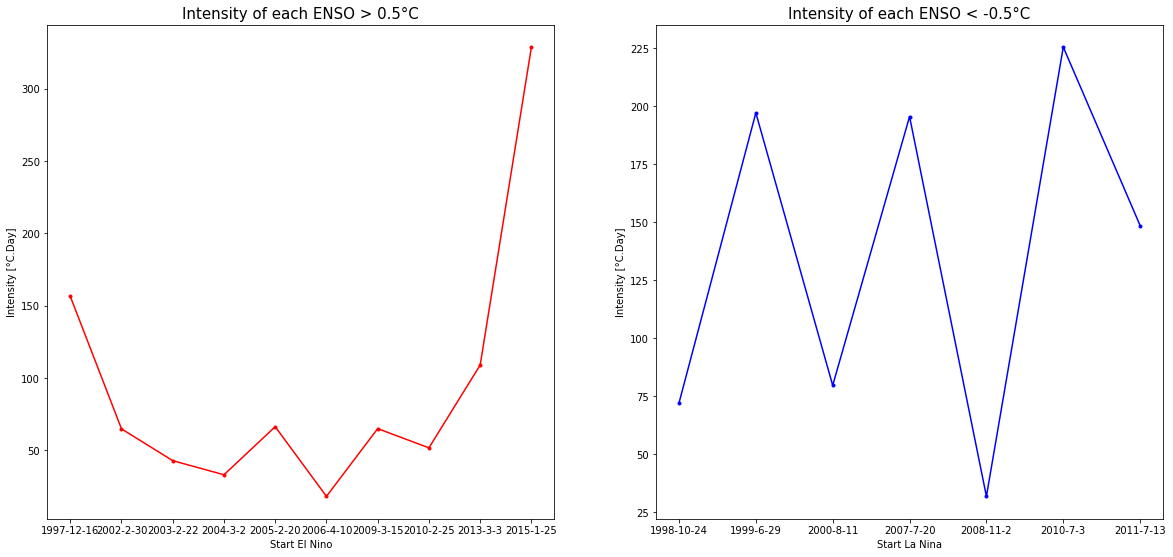

In [0]:
plt.figure()
subplot(2,2,1)
plt.plot(date,inte,'.-',color = 'red')
plt.xlabel('Start El Nino')
plt.ylabel('Intensity [°C.Day]')
plt.title('Intensity of each ENSO > 0.5°C',fontsize = 15)

subplot(2,2,2)
plt.plot(datenina,intenina,'.-',color = 'blue')
plt.xlabel('Start La Nina')
plt.ylabel('Intensity [°C.Day]')
plt.title('Intensity of each ENSO < -0.5°C',fontsize = 15)


We don't really see a clear tendency in these plots. Apart from the fact that it seems that la Nina events alternate between high intensities and lower intensities but the number of events doesn't allow us to draw conclusions.

### Events longer than 6 months

For a period to be described as an el Nino (resp la Nina) event the temperatures have to higher than 0.5 °C (resp lower than 0.5 °C) for more than 6 months in a row. That is why we have to find among the red zones (resp blue zones) the ones that last more than 6 months.

Hence we eliminate all the events that are less than 6 months long. 


In [0]:
Liste=output1.mean_sst-outputavg.mean_sst[0]
duree=0
el_nino = []
for k in range(len(Liste)):
  if Liste[k]>0.5:
    duree+=1
  elif duree >365.25/2:
    el_nino.append([output1.time[k]-duree, output1.time[k]])
    duree=0
  else:
    duree=0
if duree!=0:
  el_nino.append([output1.time[k]-duree, output1.time[k]])
el_nino = np.array(el_nino)
el_nino_greg = np.array([[juld_to_greg(x[0]),juld_to_greg(x[1])] for x in el_nino])
print('Episodes El Nino :'+ str(el_nino_greg))

Episodes El Nino :[['2015-1-25' '2015-12-15']]


We find that the only episode that can be described as an El Nino episode is the one in 2015 (strating in january 2015).


We do the same for la Nina.

In [0]:
duree=0
la_nina = []
for k in range(len(Liste)):
  if Liste[k]<-0.5:
    duree+=1
  elif duree >365.25/2:
    la_nina.append([output1.time[k]-duree, output1.time[k]])
    duree=0
  else:
    duree=0
if duree!=0:
  la_nina.append([output1.time[k]-duree, output1.time[k]])
la_nina = np.array(la_nina)
la_nina_greg = np.array([[juld_to_greg(x[0]),juld_to_greg(x[1])] for x in la_nina])
print('Episodes La Nina :'+ str(la_nina_greg))

Episodes La Nina :[['1999-6-29' '2000-1-30']
 ['2007-7-20' '2008-2-4']
 ['2010-7-3' '2011-2-9']]


We find three La nina episodes. One in 1999-2000, one in 2007-2008 and one in 2010-2011.

### SSt and SSH maps of one El Nino Event and one La Nina Event compared to normal situation   

Now we consider the maxima date during the anomaly episodes. 

In [0]:
time_begin = 729390

begin_la_nina = la_nina[:,0]
end_la_nina = la_nina[:,1]
begin_el_nino = el_nino[:,0]
end_el_nino = el_nino[:,1]

extrema = np.zeros(len(begin_la_nina) + len(begin_el_nino))
anomaly_sst = output1.mean_sst - outputavg.mean_sst[0]

for i in range(len(begin_la_nina)):
  phenomena = anomaly_sst[np.int(begin_la_nina[i] - time_begin) : np.int(end_la_nina[i] - time_begin)]
  extrema[i] = np.argmin(phenomena) + time_begin

for i in range(len(begin_el_nino)):
  phenomena = anomaly_sst[np.int(begin_el_nino[i] - time_begin) : np.int(end_el_nino[i] - time_begin)]
  extrema[i + len(begin_la_nina)] = np.argmax(phenomena) + time_begin  # Commencer à remplir à partir du nb de phénomènes la nina
print(extrema)

print(juld_to_greg(extrema[1]))

[730090. 733045. 734119. 735723.]
2007-12-19


In [0]:
%%bigquery --project alert-ground-261008 outputmax
SELECT time, lat, lon, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.1998_2015
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20 AND (time=730090 OR time=733045 OR time=734119 OR time=735723)
GROUP BY time, lat, lon
ORDER by time

In [0]:
%%bigquery --project alert-ground-261008 outputmax_ssh
SELECT time, lat, lon, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20 AND (time=730090 OR time=733045 OR time=734119 OR time=735723)
GROUP BY time, lat, lon
ORDER by time

In [0]:
%%bigquery --project alert-ground-261008 output_normal
SELECT lon, lat, AVG(sst) AS mean_sst, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20 AND ((time<729950 OR time>730164) AND (time<732894 OR time>733091) AND (time<733973 OR time>734191) AND (time<735638 OR time>735963))
GROUP BY lon, lat

We choose to show the La Nina event of 2000 and El Nino Event of 2015. See the following plots. 

We look at the Sea Surface Temperature: 

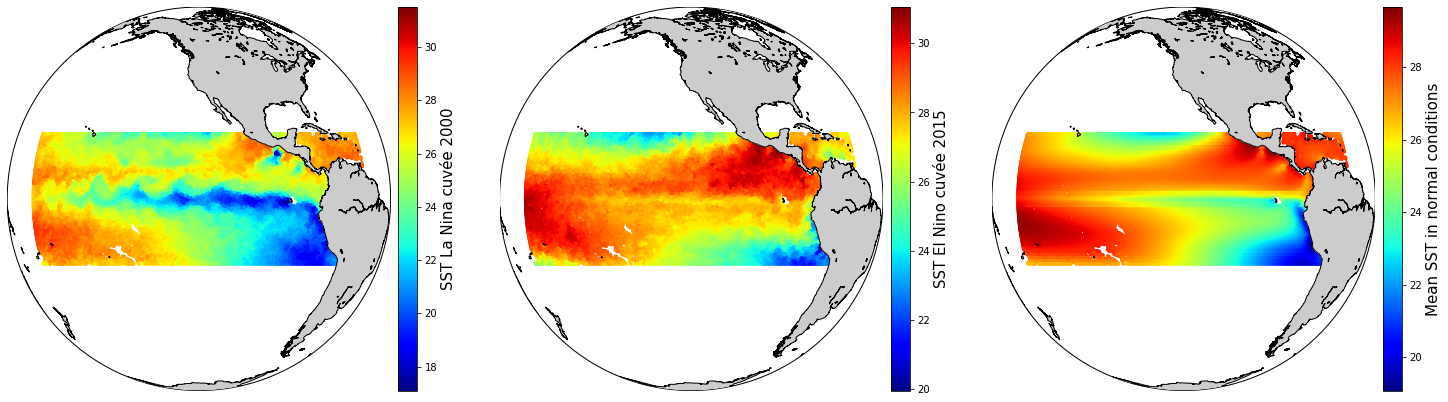

In [0]:
figure(figsize=(25,15))
subplot(1,3,1)
plot_im(outputmax.lon[outputmax.time==730090.0],outputmax.lat[outputmax.time==730090.0],outputmax.mean_sst[outputmax.time==730090.0],10,'SST La Nina cuvée 2000')
subplot(1,3,2)
plot_im(outputmax.lon[outputmax.time==735723.0],outputmax.lat[outputmax.time==735723.0],outputmax.mean_sst[outputmax.time==735723.0],10,'SST El Nino cuvée 2015')
subplot(1,3,3)
plot_im(output_normal.lon, output_normal.lat, output_normal.mean_sst, 10, 'Mean SST in normal conditions')


> The first map (from left to right) clearly shows colder temperatures than normal (last figure). The (El Nino) second shows higher temperatures.




And the Sea Surface Height :

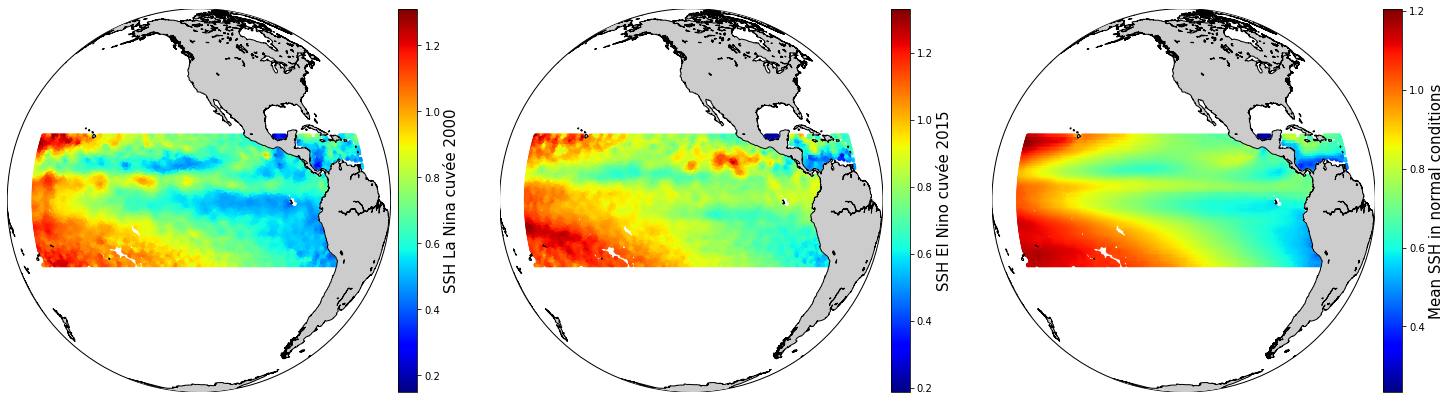

In [0]:
figure(figsize=(25,15))
subplot(1,3,1)
plot_im(outputmax_ssh.lon[outputmax_ssh.time==730090.0],outputmax_ssh.lat[outputmax_ssh.time==730090.0],outputmax_ssh.mean_ssh[outputmax_ssh.time==730090.0],10,'SSH La Nina cuvée 2000')
subplot(1,3,2)
plot_im(outputmax_ssh.lon[outputmax_ssh.time==735723.0],outputmax_ssh.lat[outputmax_ssh.time==735723.0],outputmax_ssh.mean_ssh[outputmax_ssh.time==735723.0],10,'SSH El Nino cuvée 2015')
subplot(1,3,3)
plot_im(output_normal.lon, output_normal.lat, output_normal.mean_ssh, 10, 'Mean SSH in normal conditions')

During La nina events we see a lower Sea Surface Height while during El Nino there are higher levels around central america.

#**Part 3** : Impact of La Nina events

Here we try to see the impact of La Nina on SST and SSH in the months following the event compared to a time when no extreme events were recorded in the 6 months prior. 

We chose the time 6 months after la Nina in 2007-2008 and for a normal situation we chose june 2004. 

In [0]:
%%bigquery --project alert-ground-261008 output_sst1
SELECT time, lat, lon, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.1998_2015
WHERE time=731757 
GROUP BY time, lat, lon
ORDER by time

In [0]:
%%bigquery --project alert-ground-261008 output_sst2
SELECT time, lat, lon, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.1998_2015
WHERE time=733045 + 6*30 
GROUP BY time, lat, lon
ORDER by time

In [0]:
%%bigquery --project alert-ground-261008 output_ssh1
SELECT time, lon, lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE time =731757
GROUP BY time, lon, lat
ORDER by time

In [0]:
%%bigquery --project alert-ground-261008 output_ssh2
SELECT time, lon, lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE time =733225
GROUP BY time, lon, lat
ORDER by time

We have to merge the dataframes to do the difference between the two times to make sure every point in space has a corresponding value. 

In [0]:
df1 = output_ssh1
df2 = output_ssh2

In [0]:
dfA = output_sst1
dfB = output_sst2

s2 = pd.merge(dfA, dfB, how='inner', on=['lon', 'lat'])
s1 = pd.merge(df1, df2, how='inner', on=['lon', 'lat'])

Then we plot the maps.

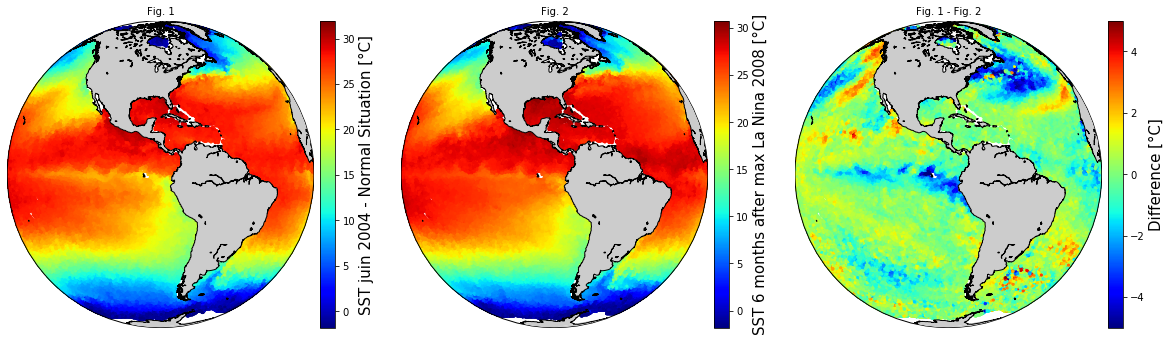

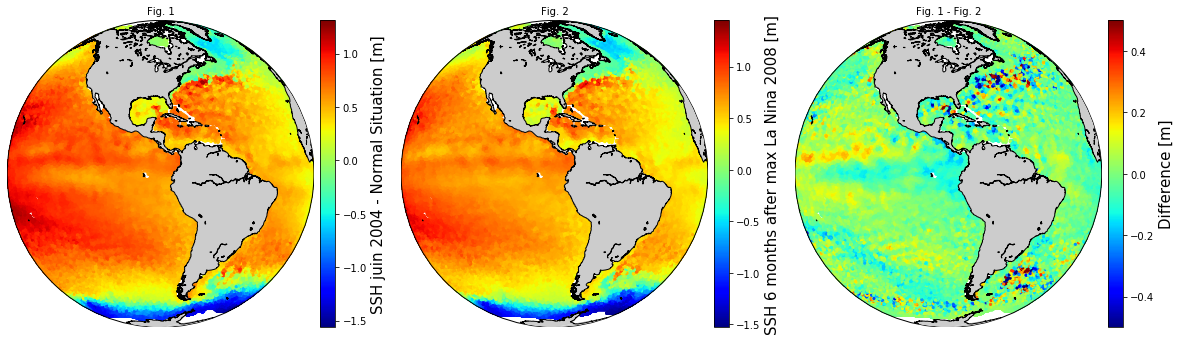

In [0]:
plt.figure()
    
subplot(2,3,1)
plot_im(output_sst1.lon,output_sst1.lat,output_sst1.mean_sst,10,'SST juin 2004 - Normal Situation [°C]')
plt.title('Fig. 1',fontsize = '10')

subplot(2,3,2)
plot_im(output_sst2.lon,output_sst2.lat,output_sst2.mean_sst,10,'SST 6 months after max La Nina 2008 [°C]')
plt.title('Fig. 2',fontsize = '10')

subplot(2,3,3)
plot_im(s2.lon,s2.lat,s2.mean_sst_x-s2.mean_sst_y,10,'Difference [°C]')
clim([-5,5])
plt.title('Fig. 1 - Fig. 2',fontsize = '10')

plt.figure()

subplot(2,3,4)
plot_im(output_ssh1.lon,output_ssh1.lat,output_ssh1.mean_ssh,10,'SSH juin 2004 - Normal Situation [m]')
plt.title('Fig. 1',fontsize = '10')

subplot(2,3,5)
plot_im(output_ssh2.lon,output_ssh2.lat,output_ssh2.mean_ssh,10,'SSH 6 months after max La Nina 2008 [m]')
plt.title('Fig. 2',fontsize = '10')

subplot(2,3,6)
plot_im(s1.lon,s1.lat,s1.mean_ssh_x-s1.mean_ssh_y,10,'Difference [m]')
plt.title('Fig. 1 - Fig. 2',fontsize = '10')
clim([-0.5,0.5])




###Impact of La Nina on temperatures


> We see that the Gulf stream seems to be colder. And the water seems hotter on the coast of California which probably brings more precipatation in this zone and hence brings humidity. 



###Impact on Height 

> We don't really see clear patterns 



Note : We couldn't do the same plots for the impact of an El Nino events since the event of 1998 is directly followed by another extreme events which is La Nina of 1999. And we don't have values for after the event of 2015.